<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Spacegroup_specific_endeavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

In [ ]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [16]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs2 = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5, band_gap=(.001, None))


Retrieving SummaryDoc documents:   0%|          | 0/225 [00:00<?, ?it/s]

In [17]:
def get_outermost_p_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    p_orbs = [(orb, e) for orb, l, e in config if l == 'p']
    highest_p = max(p_orbs, key=lambda x: x[0])  # x[0]

    return highest_p[1]


def get_outermost_s_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    s_orbs = [(orb, e) for orb, l, e in config if l == 's']
    highest_s = max(s_orbs, key=lambda x: x[0])  # x[0]

    return highest_s[1]

In [158]:
material_positions_frac = []
material_positions = []
bandgaps = []
elements_f_l = []
for m in example_docs2:
  single_material_positions = []
  single_material_frac_positions = []
  elements_l = []
  for site in m.structure.sites:
    frac_coords = site.frac_coords
    single_material_frac_positions.append(site.frac_coords)
    single_material_positions.append(site.coords)
    elements_l.append(site.specie.number)

  material_positions_frac.append(single_material_frac_positions)
  material_positions.append(single_material_positions)
  bandgaps.append(m.band_gap)
  elements_f_l.append(elements_l)

In [159]:
all_material = []

for group in material_positions_frac:
  unique_positions = []
  for coord in group:
      # Round to 4 decimal places to eliminate noise
      rounded = tuple(np.round(coord % 1, 4))  # mod 1 ensures coords are in [0, 1)
      unique_positions.append(rounded)
  all_material.append(unique_positions.copy())

In [160]:
df_temporary = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l)),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements'])

In [161]:
vdw_values = []
s_numbers= []
atomic_radius_calculated_L = []
atomic_orbitals_L = []
molar_volume_L = []
for values in df_temporary['elements']:

  vdw_values.append([Element.from_Z(number).van_der_waals_radius for number in values])
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
  atomic_orbitals_L.append([Element.from_Z(number).atomic_orbitals for number in values])
  molar_volume_L.append([Element.from_Z(number).molar_volume for number in values])
  # electron_p_number = [get_outermost_p_orbitals(number) for number in values]
  electron_s_number = [get_outermost_s_orbitals(number) for number in values]
  s_numbers.append(electron_s_number)



<ipython-input-161-71ee2590be0e>:9: UserWarning: No data available for atomic_radius_calculated for Ac
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-161-71ee2590be0e>:9: UserWarning: No data available for atomic_radius_calculated for Ce
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-161-71ee2590be0e>:9: UserWarning: No data available for atomic_radius_calculated for Th
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-161-71ee2590be0e>:9: UserWarning: No data available for atomic_radius_calculated for Pa
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-161-71ee2590be0e>:9: UserWarning: No data available for atomic_radius_calculated for U
  atomic_radius_calculated_L.append([Element.from_Z(nu

In [162]:
df_temporary_2 = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l, vdw_values, s_numbers, atomic_radius_calculated_L, atomic_orbitals_L, molar_volume_L)),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements', ' vdw_values', 's_numbers', 'atomic_radius_calculated_L', 'atomic_orbitals_L', 'molar_volume_L' ])
df_temporary_2

,all_material,material_positions,bandgaps,elements,vdw_values,s_numbers,atomic_radius_calculated_L,atomic_orbitals_L,molar_volume_L
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024,"[89, 13, 8, 8, 8]","[2.47 ang, 1.84 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.18 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 10.0 cm^3, 17.36 cm^3, 17.36 cm^3..."
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071,"[89, 5, 8, 8, 8]","[2.47 ang, 1.92 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 0.87 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 4.39 cm^3, 17.36 cm^3, 17.36 cm^3..."
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031,"[89, 24, 8, 8, 8]","[2.47 ang, 2.06 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.66 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.23 cm^3, 17.36 cm^3, 17.36 cm^3..."
3,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888,"[89, 26, 8, 8, 8]","[2.47 ang, 2.04 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.09 cm^3, 17.36 cm^3, 17.36 cm^3..."
4,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9731310450000001, 1.97313...",2.8959,"[89, 31, 8, 8, 8]","[2.47 ang, 1.87 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.36 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 11.8 cm^3, 17.36 cm^3, 17.36 cm^3..."
...,...,...,...,...,...,...,...,...,...
220,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [2.035064503667284, 2.035064...",1.7075,"[70, 50, 8, 8, 8]","[2.26 ang, 2.17 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.22 ang, 1.45 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -2084.069389, '2p': -323.178219, '2s':...","[24.84 cm^3, 16.29 cm^3, 17.36 cm^3, 17.36 cm^..."
221,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.919573494837641, 1.919573...",1.8975,"[70, 22, 8, 8, 8]","[2.26 ang, 2.11 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.22 ang, 1.76 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -2084.069389, '2p': -323.178219, '2s':...","[24.84 cm^3, 10.64 cm^3, 17.36 cm^3, 17.36 cm^..."
222,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.5, ...","[[2.0365395, 2.0365395, 2.0365395], [0.0, 0.0,...",1.5852,"[30, 47, 9, 9, 9]","[2.01 ang, 2.11 ang, 1.47 ang, 1.47 ang, 1.47 ...","[2, 1, 2, 2, 2]","[1.42 ang, 1.65 ang, 0.42 ang, 0.42 ang, 0.42 ...","[{'1s': -344.969756, '2p': -36.648765, '2s': -...","[9.16 cm^3, 10.27 cm^3, 11.2 cm^3, 11.2 cm^3, ..."
223,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.734581, 1.734581, 1.73458...",0.6259,"[40, 4, 8, 8, 8]","[2.23 ang, 1.53 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.12 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 4.85 cm^3, 17.36 cm^3, 17.36 cm^3..."


In [163]:
import numpy as np

def find_wyckoff_1b_3c_indices(coords):
    # Normalize and round for matching
    rounded_coords = [tuple(np.round(np.array(c) % 1, 6)) for c in coords]

    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c_list = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    # Find index of 1b
    try:
        i1b = rounded_coords.index(wyckoff_1b)
    except ValueError:
        i1b = None

    # Find index of any 3c
    i3c = None
    for w3c in wyckoff_3c_list:
        if w3c in rounded_coords:
            i3c = rounded_coords.index(w3c)
            break

    both_found = i1b is not None and i3c is not None

    return i1b, i3c, both_found

In [164]:
df_temporary_2

,all_material,material_positions,bandgaps,elements,vdw_values,s_numbers,atomic_radius_calculated_L,atomic_orbitals_L,molar_volume_L
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024,"[89, 13, 8, 8, 8]","[2.47 ang, 1.84 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.18 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 10.0 cm^3, 17.36 cm^3, 17.36 cm^3..."
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071,"[89, 5, 8, 8, 8]","[2.47 ang, 1.92 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 0.87 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 4.39 cm^3, 17.36 cm^3, 17.36 cm^3..."
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031,"[89, 24, 8, 8, 8]","[2.47 ang, 2.06 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.66 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.23 cm^3, 17.36 cm^3, 17.36 cm^3..."
3,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888,"[89, 26, 8, 8, 8]","[2.47 ang, 2.04 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.09 cm^3, 17.36 cm^3, 17.36 cm^3..."
4,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9731310450000001, 1.97313...",2.8959,"[89, 31, 8, 8, 8]","[2.47 ang, 1.87 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.36 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 11.8 cm^3, 17.36 cm^3, 17.36 cm^3..."
...,...,...,...,...,...,...,...,...,...
220,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [2.035064503667284, 2.035064...",1.7075,"[70, 50, 8, 8, 8]","[2.26 ang, 2.17 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.22 ang, 1.45 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -2084.069389, '2p': -323.178219, '2s':...","[24.84 cm^3, 16.29 cm^3, 17.36 cm^3, 17.36 cm^..."
221,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.919573494837641, 1.919573...",1.8975,"[70, 22, 8, 8, 8]","[2.26 ang, 2.11 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.22 ang, 1.76 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -2084.069389, '2p': -323.178219, '2s':...","[24.84 cm^3, 10.64 cm^3, 17.36 cm^3, 17.36 cm^..."
222,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.0, 0.5, ...","[[2.0365395, 2.0365395, 2.0365395], [0.0, 0.0,...",1.5852,"[30, 47, 9, 9, 9]","[2.01 ang, 2.11 ang, 1.47 ang, 1.47 ang, 1.47 ...","[2, 1, 2, 2, 2]","[1.42 ang, 1.65 ang, 0.42 ang, 0.42 ang, 0.42 ...","[{'1s': -344.969756, '2p': -36.648765, '2s': -...","[9.16 cm^3, 10.27 cm^3, 11.2 cm^3, 11.2 cm^3, ..."
223,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.734581, 1.734581, 1.73458...",0.6259,"[40, 4, 8, 8, 8]","[2.23 ang, 1.53 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.12 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 4.85 cm^3, 17.36 cm^3, 17.36 cm^3..."


In [165]:
distances = []
band_gaps = []
elements_1b = []
elements_3c = []
electrons_1b_s = []
electrons_3c_s = []

atomic_radiuss_1b = []
atomic_radiuss_3c = []

atomic_orbitalss_1b_largest_1 = []
atomic_orbitalss_1b_largest_2 = []
atomic_orbitalss_1b_largest_3 = []

atomic_orbitalss_3c_largest_1 = []
atomic_orbitalss_3c_largest_2 = []
atomic_orbitalss_3c_largest_3 = []


molar_volumess_1b = []
molar_volumess_3c = []
van_der_waals_radius_sum = []
vanderwaals_1b = []
vanderwaals_3c = []

electronegativity_differences = []
en1_L = []
en2_L = []


for data in df_temporary_2.values:
  pos1b, pos3c, both = find_wyckoff_1b_3c_indices(data[0])
  if both and data[7][pos1b] != None:
    distance = np.linalg.norm(data[1][pos1b] - data[1][pos3c])
    distances.append(distance)
    band_gaps.append(data[2])

    van_der_waals_radius_sum.append(data[4][pos1b] + data[4][pos3c])

    electrons_1b_s.append(data[5][pos1b])
    electrons_3c_s.append(data[5][pos3c])

    atomic_radiuss_1b.append(data[6][pos1b])
    atomic_radiuss_3c.append(data[6][pos3c])

    molar_volumess_1b.append(data[8][pos1b])
    molar_volumess_3c.append(data[8][pos3c])

    vanderwaals_1b.append(data[4][pos1b])
    vanderwaals_3c.append(data[4][pos3c])
    elements_1b.append(data[3][pos1b])
    elements_3c.append(data[3][pos3c])

    en1 = Element.from_Z(data[3][pos1b]).X or 0  # Electronegativity of 1b atom
    en2 = Element.from_Z(data[3][pos3c]).X or 0  # Electronegativity of 3c atom
    en1_L.append(en1)
    en2_L.append(en2)
    electronegativity_differences.append(abs(en1 - en2))

    atomic_orbitalss_1b_largest_1.append(list(data[7][pos1b].values())[-1])
    # atomic_orbitalss_1b_largest_2.append(list(data[7][pos1b].values())[-2])
    # atomic_orbitalss_1b_largest_3.append(list(data[7][pos1b].values())[-3])

    atomic_orbitalss_3c_largest_1.append(list(data[7][pos3c].values())[-1])
    # atomic_orbitalss_3c_largest_2.append(list(data[7][pos3c].values())[-2])
    # atomic_orbitalss_3c_largest_3.append(list(data[7][pos3c].values())[-3])

In [166]:
van_der_waals_radius_sum = np.array(van_der_waals_radius_sum)
distances = np.array(distances)

overlap = van_der_waals_radius_sum - distances

In [167]:
df_final = pd.DataFrame(list(zip(bandgaps, vanderwaals_1b,vanderwaals_3c, van_der_waals_radius_sum, distances, overlap, elements_1b,elements_3c,  electrons_1b_s, electrons_3c_s, atomic_radiuss_1b, atomic_radiuss_3c, atomic_orbitalss_1b_largest_1, atomic_orbitalss_3c_largest_1, molar_volumess_1b, molar_volumess_3c, en1_L, en2_L, electronegativity_differences)),
                  columns =['bandgaps','vanderwaals_1b','vanderwaals_3c', 'van_der_waals_radius_sum', 'distances', 'overlap','elements_1b','elements_3c', 'electrons_1b_s', 'electrons_3c_s', 'atomic_radiuss_1b', 'atomic_radiuss_3c', 'atomic_orbitalss_1b_largest_1', 'atomic_orbitalss_3c_largest_1', 'molar_volumess_1b', 'molar_volumess_3c', 'en1', 'en2', 'electronegativity_differences'])

In [168]:
df = df_final[df_final['bandgaps'] > 0]

In [169]:
df

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c,en1,en2,electronegativity_differences
0,4.1024,1.84,1.52,3.36,1.929317,1.430683,13,8,2,2,1.18,0.48,-0.286883,-0.871362,10.00,17.36,1.61,3.44,1.83
1,0.8071,1.92,1.52,3.44,1.860834,1.579166,5,8,2,2,0.87,0.48,-0.344701,-0.871362,4.39,17.36,2.04,3.44,1.40
2,2.0031,2.06,1.52,3.58,1.972136,1.607864,24,8,1,2,1.66,0.48,-0.150445,-0.871362,7.23,17.36,1.66,3.44,1.78
3,0.9888,1.87,1.52,3.39,1.973131,1.416869,31,8,2,2,1.36,0.48,-0.328019,-0.871362,11.80,17.36,1.81,3.44,1.63
4,2.8959,2.15,1.52,3.67,2.062523,1.607477,21,8,2,2,1.84,0.48,-0.156478,-0.871362,15.00,17.36,1.36,3.44,2.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2.6427,2.10,1.52,3.62,1.815811,1.804189,14,8,2,2,1.11,0.48,-0.398139,-0.871362,12.06,17.36,1.90,3.44,1.54
153,1.6958,2.17,1.52,3.69,2.035065,1.654935,50,8,2,2,1.45,0.48,-0.369349,-0.871362,16.29,17.36,1.96,3.44,1.48
154,1.6185,2.11,1.52,3.63,1.919573,1.710427,22,8,2,2,1.76,0.48,-0.167106,-0.871362,10.64,17.36,1.54,3.44,1.90
155,1.8470,2.01,1.47,3.48,2.036539,1.443460,30,9,2,2,1.42,0.42,-0.222725,-1.086859,9.16,11.20,1.65,3.98,2.33


In [170]:
df.corr(method='spearman')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c,en1,en2,electronegativity_differences
bandgaps,1.000000,0.058589,-0.177771,-0.085997,0.050317,-0.141588,0.050646,-0.057150,-0.028048,-0.158092,0.171847,-0.114093,0.149636,-0.099414,0.058458,-0.193626,-0.154425,0.100457,0.139977
vanderwaals_1b,0.058589,1.000000,-0.364805,0.264575,0.135311,0.327753,0.763664,-0.357946,0.021947,0.092127,0.837018,-0.298625,0.711053,-0.301524,0.351906,-0.278503,-0.630071,0.300504,0.132380
vanderwaals_3c,-0.177771,-0.364805,1.000000,0.643535,0.418288,0.049711,-0.141363,0.534653,0.136002,0.078034,-0.505326,0.835659,-0.575498,0.792518,0.134015,0.914392,0.592974,-0.793778,-0.290293
van_der_waals_radius_sum,-0.085997,0.264575,0.643535,1.000000,0.785509,0.162316,0.350047,0.563752,0.181116,0.028315,0.028800,0.574272,-0.103150,0.535001,0.546789,0.635496,0.178203,-0.540104,-0.022869
distances,0.050317,0.135311,0.418288,0.785509,1.000000,-0.394753,0.276226,0.685691,0.202459,-0.179000,0.067649,0.520464,-0.070028,0.496671,0.662266,0.387039,0.113442,-0.501858,0.011941
overlap,-0.141588,0.327753,0.049711,0.162316,-0.394753,1.000000,0.222821,-0.377484,-0.046917,0.191750,0.071077,-0.163112,0.086664,-0.162607,-0.159583,0.087653,0.001232,0.164426,0.127131
elements_1b,0.050646,0.763664,-0.141363,0.350047,0.276226,0.222821,1.000000,-0.169270,0.072455,0.196699,0.678807,-0.190885,0.441240,-0.207279,0.303248,-0.109061,-0.308713,0.206888,0.013515
elements_3c,-0.057150,-0.357946,0.534653,0.563752,0.685691,-0.377484,-0.169270,1.000000,0.161641,0.166658,-0.372902,0.361845,-0.449728,0.303997,0.227770,0.437840,0.452549,-0.312009,0.096217
electrons_1b_s,-0.028048,0.021947,0.136002,0.181116,0.202459,-0.046917,0.072455,0.161641,1.000000,-0.006410,-0.207517,0.122067,-0.334720,0.114821,0.272471,0.106460,0.133690,-0.114821,-0.006632
electrons_3c_s,-0.158092,0.092127,0.078034,0.028315,-0.179000,0.191750,0.196699,0.166658,-0.006410,1.000000,0.064469,-0.348365,0.023216,-0.424169,-0.337527,0.105345,0.022197,0.416367,0.095398


In [171]:
df.corr(method='kendall')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c,en1,en2,electronegativity_differences
bandgaps,1.000000,0.042400,-0.135555,-0.054008,0.037890,-0.094235,0.034142,-0.039554,-0.022974,-0.129492,0.119418,-0.083877,0.103914,-0.075927,0.035134,-0.151258,-0.109705,0.075936,0.095218
vanderwaals_1b,0.042400,1.000000,-0.278000,0.341830,0.150432,0.240874,0.554981,-0.271134,0.018251,0.076611,0.688825,-0.218018,0.564893,-0.220441,0.268544,-0.213978,-0.493130,0.218246,0.102275
vanderwaals_3c,-0.135555,-0.278000,1.000000,0.521310,0.275285,0.056846,-0.102419,0.418723,0.124041,0.071171,-0.390643,0.810353,-0.454146,0.776004,0.110267,0.863812,0.468705,-0.779969,-0.233468
van_der_waals_radius_sum,-0.054008,0.341830,0.521310,1.000000,0.608760,0.123269,0.263356,0.438020,0.149732,0.023409,0.092903,0.458291,-0.035810,0.429792,0.398248,0.514486,0.111274,-0.433055,-0.010313
distances,0.037890,0.150432,0.275285,0.608760,1.000000,-0.275029,0.188070,0.547787,0.165833,-0.146618,0.119049,0.372678,0.007523,0.345249,0.462196,0.250440,0.003144,-0.348471,0.046785
overlap,-0.094235,0.240874,0.056846,0.123269,-0.275029,1.000000,0.163269,-0.298341,-0.038430,0.157061,0.060815,-0.085468,0.058777,-0.092225,-0.102922,0.063007,-0.006453,0.092237,0.085334
elements_1b,0.034142,0.554981,-0.102419,0.263356,0.188070,0.163269,1.000000,-0.128175,0.060048,0.163018,0.429753,-0.144071,0.278266,-0.155742,0.219349,-0.078475,-0.179237,0.155962,-0.010340
elements_3c,-0.039554,-0.271134,0.418723,0.438020,0.547787,-0.298341,-0.128175,1.000000,0.147426,0.152002,-0.277896,0.230527,-0.338245,0.194727,0.165803,0.369134,0.340025,-0.198621,0.107562
electrons_1b_s,-0.022974,0.018251,0.124041,0.149732,0.165833,-0.038430,0.060048,0.147426,1.000000,-0.006410,-0.172581,0.111332,-0.277406,0.104723,0.225815,0.097098,0.110881,-0.104736,-0.005477
electrons_3c_s,-0.129492,0.076611,0.071171,0.023409,-0.146618,0.157061,0.163018,0.152002,-0.006410,1.000000,0.053615,-0.317729,0.019241,-0.386867,-0.279731,0.096081,0.018410,0.379796,0.078791


In [172]:
import pandas as pd
import itertools
import numpy as np
from sklearn.feature_selection import mutual_info_regression

def generate_power_interactions(df, target_col, method="pearson", max_features=4, max_power=4):
    results = []
    features = [col for col in df.columns if col != target_col]
    target = df[target_col]

    for feature_combo in itertools.combinations(features, r=3):  # only 3-feature combos
        # All power combinations: (1,1,1) to (3,3,3)
        for powers in itertools.product(range(1, max_power + 1), repeat=3):
            try:
                term = (df[feature_combo[0]] ** powers[0]) * \
                       (df[feature_combo[1]] ** powers[1]) * \
                       (df[feature_combo[2]] ** powers[2])

                name = f"{feature_combo[0]}^{powers[0]}*{feature_combo[1]}^{powers[1]}*{feature_combo[2]}^{powers[2]}"

                # Correlation or mutual info
                if method == "pearson":
                    score = term.corr(target)
                elif method == "spearman":
                    score = term.corr(target, method="spearman")
                elif method == "mutual_info":
                    score = mutual_info_regression(term.to_frame(), target)[0]
                else:
                    raise ValueError("Unknown method")

                results.append((name, score))
            except Exception as e:
                results.append((name, f"Error: {e}"))

    # Sort results numerically by abs(score), ignore errors
    results = [r for r in results if isinstance(r[1], (float, int, np.number))]
    results.sort(key=lambda x: abs(x[1]), reverse=True)
    return results

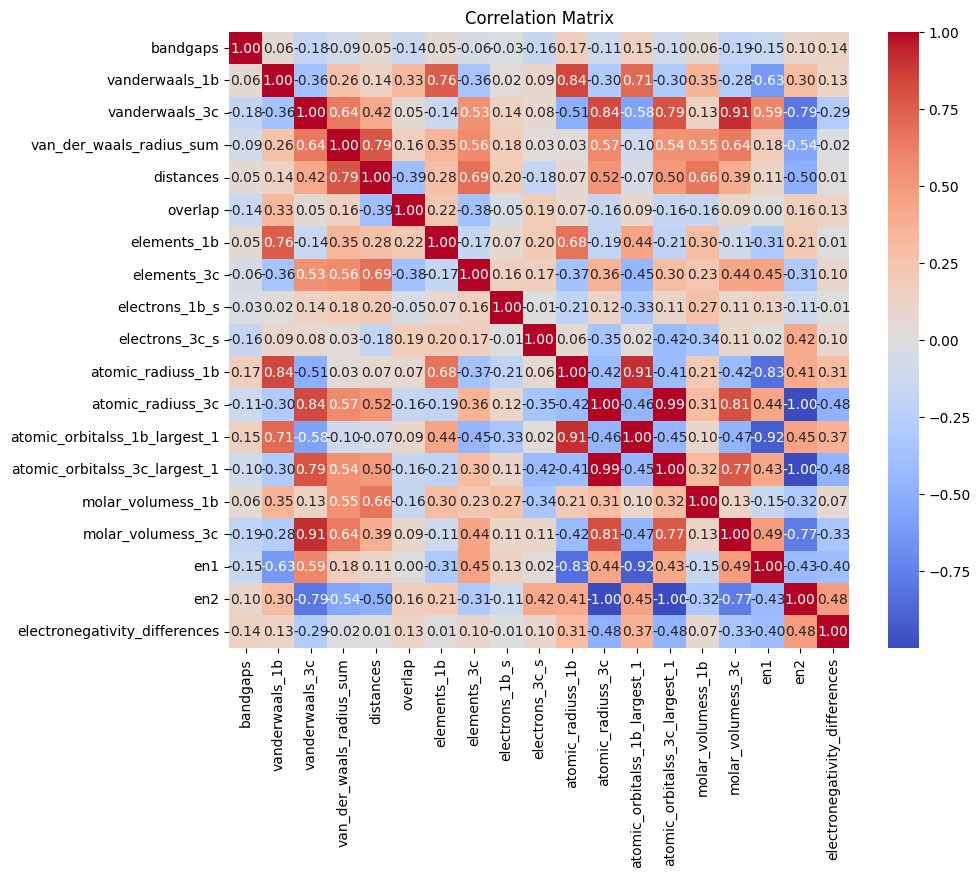

In [173]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(method = 'spearman', numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

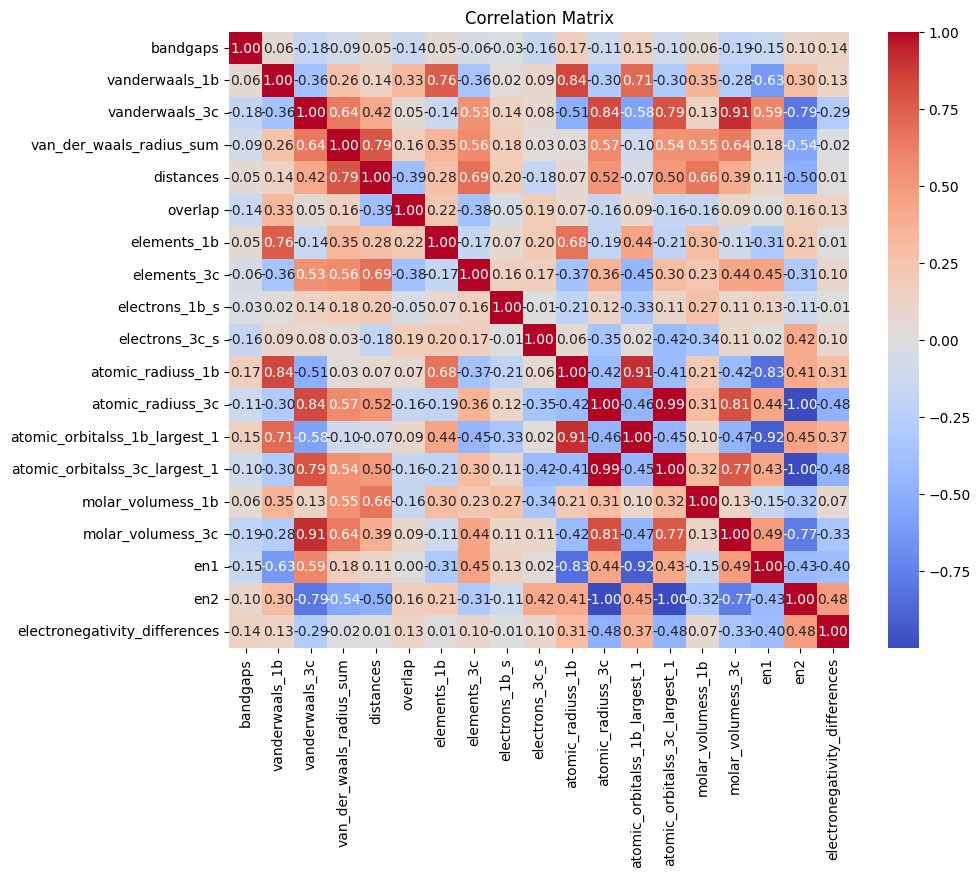

In [174]:
df_sorted = df_final.sort_values(by="bandgaps")
plt.figure(figsize=(10, 8))
sns.heatmap(df_sorted.corr(method = 'spearman', numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [175]:
# Check if data changed
print(df_final.info())
print(df_final.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bandgaps                       157 non-null    float64
 1   vanderwaals_1b                 157 non-null    float64
 2   vanderwaals_3c                 157 non-null    float64
 3   van_der_waals_radius_sum       157 non-null    float64
 4   distances                      157 non-null    float64
 5   overlap                        157 non-null    float64
 6   elements_1b                    157 non-null    int64  
 7   elements_3c                    157 non-null    int64  
 8   electrons_1b_s                 157 non-null    int64  
 9   electrons_3c_s                 157 non-null    int64  
 10  atomic_radiuss_1b              149 non-null    float64
 11  atomic_radiuss_3c              157 non-null    float64
 12  atomic_orbitalss_1b_largest_1  157 non-null    flo

In [176]:
mutualinfo = generate_power_interactions(df, "bandgaps", method="spearman",max_features= 3, max_power = 2)


In [177]:
append_features = []
append_values =[]
for (name, number) in mutualinfo:

  append_features.append(name)
  append_values.append(number)





In [178]:
df_new_mi = pd.DataFrame(list(zip(append_features, append_values)), columns =['features', 'values'])


df_new_mi



,features,values
0,overlap^1*electrons_3c_s^2*molar_volumess_3c^1,-0.304749
1,vanderwaals_3c^2*overlap^1*electrons_3c_s^2,-0.299003
2,overlap^2*electrons_3c_s^2*atomic_orbitalss_1b...,0.295425
3,overlap^2*electrons_3c_s^2*molar_volumess_3c^1,-0.295310
4,overlap^1*electrons_3c_s^2*molar_volumess_3c^2,-0.294203
...,...,...
6523,overlap^1*electrons_3c_s^1*atomic_orbitalss_3c...,0.000112
6524,distances^2*overlap^1*molar_volumess_1b^1,-0.000090
6525,atomic_orbitalss_1b_largest_1^1*atomic_orbital...,0.000026
6526,atomic_orbitalss_1b_largest_1^2*atomic_orbital...,0.000026


In [73]:
df_new_mi3

,features,values
0,elements_3c^2*electrons_1b_s^3*molar_volumess_...,0.073305
1,van_der_waals_radius_sum^1*electrons_1b_s^3*at...,0.071452
2,electrons_1b_s^1*electrons_3c_s^3*atomic_orbit...,0.065689
3,electrons_3c_s^1*atomic_orbitalss_1b_largest_1...,0.060778
4,vanderwaals_3c^1*elements_3c^1*electrons_1b_s^2,0.060184
...,...,...
7717,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
7718,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
7719,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
7720,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000


In [ ]:
df_new_mi = pd.DataFrame(list(zip(append_features, append_values)), columns =['features', 'values'])
df_new_mi.nlargest(n=5, columns="values")

,features,values
1,vanderwaals_3c*overlap*atomic_radiuss_1b*atomi...,0.373286
2,overlap*atomic_radiuss_1b*atomic_orbitalss_1b_...,0.360295
3,van_der_waals_radius_sum*overlap*atomic_radius...,0.359054
4,overlap*elements_1b*elements_3c*atomic_orbital...,0.357740
5,overlap*elements_1b*atomic_radiuss_3c*atomic_o...,0.354930


In [ ]:
df_final.corr(method='spearman')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
bandgaps,1.000000,-0.026703,-0.247326,-0.279796,-0.201587,-0.011933,-0.157699,-0.198494,-0.099908,0.086495,0.127944,-0.265534,0.294175,-0.265534,-0.187714,-0.259992
vanderwaals_1b,-0.026703,1.000000,-0.349896,0.106798,0.013945,0.442849,0.697762,-0.400826,-0.135374,0.209913,0.759279,-0.385991,0.503540,-0.385844,0.176344,-0.163516
vanderwaals_3c,-0.247326,-0.349896,1.000000,0.868873,0.784712,-0.359504,0.202005,0.954531,0.334644,0.056929,-0.482561,0.965531,-0.806063,0.965501,0.500307,0.847397
van_der_waals_radius_sum,-0.279796,0.106798,0.868873,1.000000,0.869797,-0.158182,0.531664,0.828927,0.207249,0.055655,-0.105021,0.838337,-0.588533,0.838418,0.653001,0.750375
distances,-0.201587,0.013945,0.784712,0.869797,1.000000,-0.553610,0.546094,0.777325,0.112068,-0.029917,0.030847,0.798817,-0.491917,0.799058,0.823180,0.753024
overlap,-0.011933,0.442849,-0.359504,-0.158182,-0.553610,1.000000,-0.061058,-0.377034,-0.022030,0.103997,0.087833,-0.419347,0.269125,-0.421221,-0.456973,-0.427831
elements_1b,-0.157699,0.697762,0.202005,0.531664,0.546094,-0.061058,1.000000,0.128914,-0.010555,0.194101,0.635830,0.154628,0.079614,0.155325,0.571792,0.299549
elements_3c,-0.198494,-0.400826,0.954531,0.828927,0.777325,-0.377034,0.128914,1.000000,0.244968,-0.034157,-0.472426,0.920062,-0.772065,0.919176,0.481297,0.758598
electrons_1b_s,-0.099908,-0.135374,0.334644,0.207249,0.112068,-0.022030,-0.010555,0.244968,1.000000,0.171726,-0.367535,0.244968,-0.446208,0.244968,0.133383,0.273402
electrons_3c_s,0.086495,0.209913,0.056929,0.055655,-0.029917,0.103997,0.194101,-0.034157,0.171726,1.000000,0.065654,-0.095966,0.028544,-0.095966,0.034253,0.352960


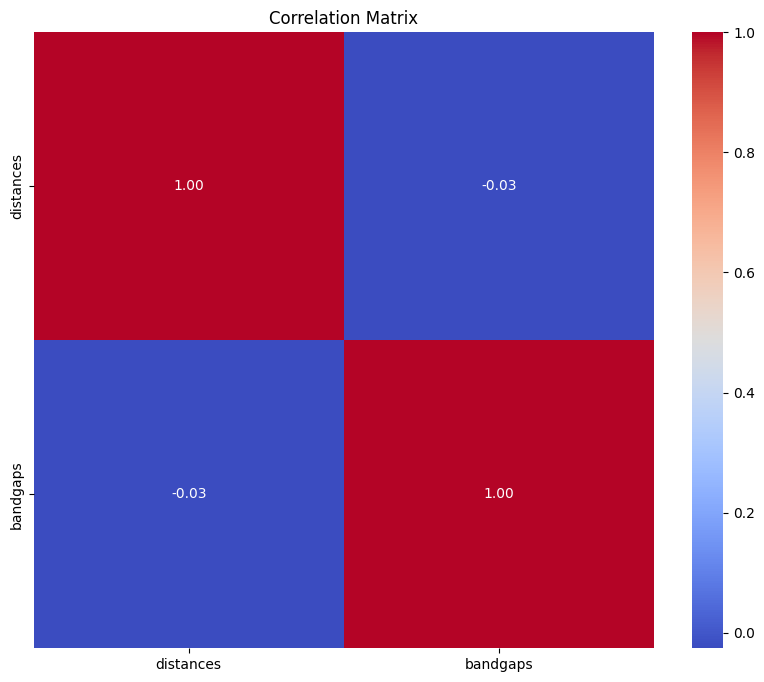

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

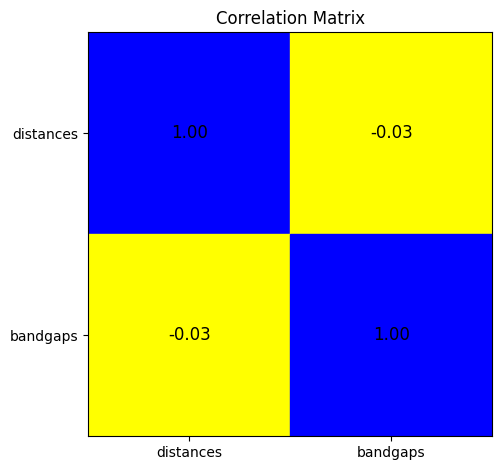

In [ ]:
# Compute correlation matrix
corr = df.corr()

# Extract values and labels
values = corr.values
labels = corr.columns.tolist()

# Create custom color matrix
colors = np.array([
    ['blue' if i == j else 'yellow' for j in range(2)]
    for i in range(2)
])

# Plot
fig, ax = plt.subplots()

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i][j]))
        ax.text(j + 0.5, i + 0.5, f"{values[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=12)

# Axis formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()